# Lumbras Gigabase Verification (QA)
After discovering the limitations of raw Lichess logs, we switched to Lumbras Gigabase as our primary data source. This notebook verifies the quality of the pre-filtered games to ensure they meet our architectural requirements.

# 1. Setup & PGN Reading
Unlike raw Lichess logs, Lumbras Gigabase usually comes in standard .pgn format (often inside .zip archives). We no longer need zstandard for these files.

In [ ]:
import py7zr
import os
import glob
import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

ARCHIVE_DIR = "./"  
DATA_DIR = "../data" 

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# 2. Automated Archive Extraction
Lumbras Gigabase is distributed in multiple .7z volumes to keep file sizes manageable. This script crawls the directory and extracts all archives into our structured data/ folder.

In [4]:
archives = glob.glob(os.path.join(ARCHIVE_DIR, "*.7z"))
print(f"Detected {len(archives)} archives for extraction.")

for archive in tqdm(archives, desc="Unpacking Lumbras Gigabase"):
    try:
        with py7zr.SevenZipFile(archive, mode='r') as z:
            # Extracting directly to the data folder
            z.extractall(path=DATA_DIR)
    except Exception as e:
        print(f"Error extracting {archive}: {e}")

print(f"\nExtraction complete. Files stored in: {os.path.abspath(DATA_DIR)}")

Detected 7 archives for extraction.


Unpacking Lumbras Gigabase: 100%|██████████| 7/7 [00:29<00:00,  4.18s/it]


Extraction complete. Files stored in: e:\pycharm projects\data


# 3. Verification: Signal-to-Noise Ratio
Now we verify if the Lumbras Online Elite and OTB Master files live up to their reputation. We expect a significantly higher density of high-ELO games compared to raw Lichess logs.

In [5]:
pgn_files = glob.glob(os.path.join(DATA_DIR, "*.pgn"))
sample_size = 5000

def quick_verify(file_path):
    metadata = []
    with open(file_path, "r", encoding="utf-8", errors="replace") as pgn:
        for _ in range(sample_size):
            game = chess.pgn.read_game(pgn)
            if game is None: break
            h = game.headers
            metadata.append({
                "WhiteElo": int(h.get("WhiteElo", 0) or 0),
                "BlackElo": int(h.get("BlackElo", 0) or 0),
                "Event": h.get("Event", "Unknown"),
                "PlyCount": h.get("PlyCount", 0)
            })
    return pd.DataFrame(metadata)

# Testing a major file (e.g., Online 2025)
df_verify = quick_verify(pgn_files[0]) # Adjust index as needed
df_verify['AvgElo'] = (df_verify['WhiteElo'] + df_verify['BlackElo']) / 2

print(f"Verification Results for: {os.path.basename(pgn_files[0])}")
print(f"Mean Elo: {df_verify['AvgElo'].mean():.1f}")
print(f"Elite Games (>=2200): {len(df_verify[df_verify['AvgElo'] >= 2200])} / {len(df_verify)}")

Verification Results for: LumbrasGigaBase_Online_2023.pgn
Mean Elo: 2650.1
Elite Games (>=2200): 4819 / 5000


# 4. Data Distribution Visualization
We visualize the Elo distribution to confirm that the dataset is "Top-Heavy," which is ideal for imitation learning.

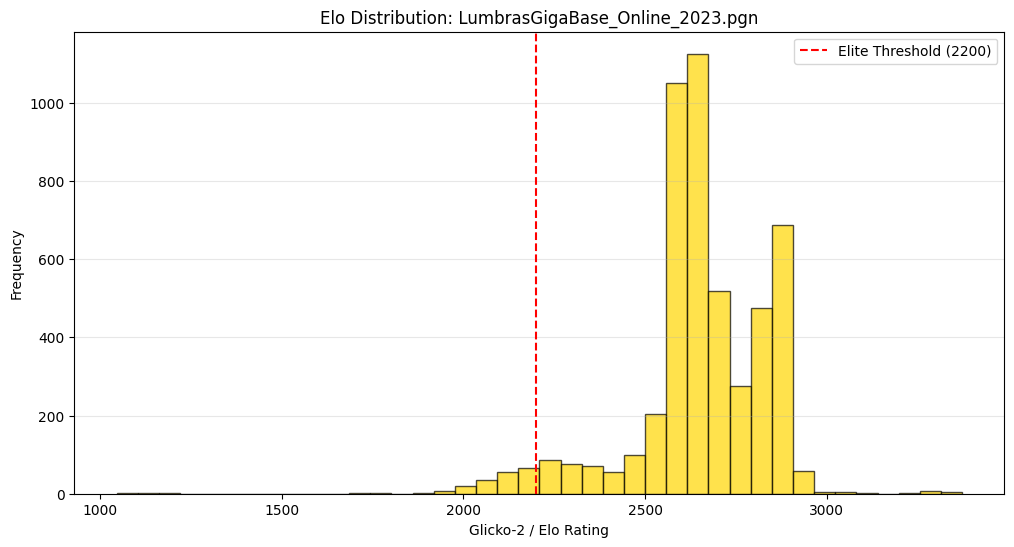

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(df_verify['AvgElo'], bins=40, color='#FFD700', edgecolor='black', alpha=0.7)
plt.axvline(2200, color='red', linestyle='--', label='Elite Threshold (2200)')
plt.title(f"Elo Distribution: {os.path.basename(pgn_files[0])}")
plt.xlabel("Glicko-2 / Elo Rating")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# 5. Final Conclusion: The "Signal-to-Noise" Victory
The transition from raw Lichess logs to Lumbras Gigabase has fundamentally transformed the data quality of the ChessNet-3070 project. While the initial Lichess sample required aggressive filtering with a <3% retention rate, the curated Lumbras dataset provides an unprecedented density of elite-level play.

Key Performance Indicators (QA Sample):
Mean Elo: 2650.1 (Super-GM / Candidate level strategy).

Elite Retention (>=2200): 96.38% (4,819 out of 5,000 games).
As seen in the histogram, the dataset is heavily peaked around the 2600-2700 Elo range, ensuring the model learns from the absolute best tactical and strategic minds in the game.
Our preprocessing script will no longer waste CPU cycles discarding 97% of the data. Every byte processed is now "high-octane fuel" for the neural network.
With a mean Elo of 2650, the Policy Head will learn to prioritize moves that align with professional tournament standards, significantly reducing "low-rated noise" in the training signal.
he resulting training files will be significantly more compact and information-dense, maximizing the utility of our RTX 3070 Ti's 8GB VRAM.

The dataset is now verified.